In [108]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.optim import SGD
from torch.nn import L1Loss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [109]:
# Link the jupyter notebook to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


   longitude  latitude  ...  median_income  median_house_value
0    -122.23     37.88  ...         8.3252            452600.0
1    -122.22     37.86  ...         8.3014            358500.0
2    -122.24     37.85  ...         7.2574            352100.0
3    -122.25     37.85  ...         5.6431            341300.0
4    -122.25     37.85  ...         3.8462            342200.0
5    -122.25     37.85  ...         4.0368            269700.0
6    -122.25     37.84  ...         3.6591            299200.0
7    -122.25     37.84  ...         3.1200            241400.0
8    -122.26     37.84  ...         2.0804            226700.0
9    -122.25     37.84  ...         3.6912            261100.0

[10 rows x 9 columns]


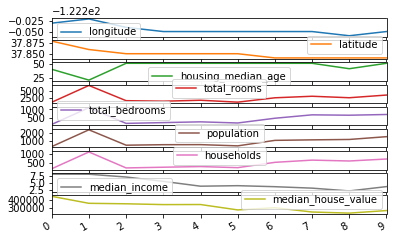

In [110]:
# Load the dataset and noemalize it
dataset = pd.read_csv("/content/housing.csv")
dataset.dropna(inplace =True)
dataset.drop('ocean_proximity',axis=1,inplace=True)

X = dataset.loc[:,'longitude':'median_income']
Y = dataset["median_house_value"]

# Prine the first 10 rows of the dataset
print(dataset.head(10))

# Plot the first 10 rows of the dataset
dataset.head(10).plot(subplots=True)

# Normalize the data using Standard Scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)



In [0]:
# Split the data into training and testing sets with random seed = 2003
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=2003)


In [0]:
# Convert the labels into arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


In [0]:
# Import the Libraries for building the model 
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu

from torch.utils.data import DataLoader, TensorDataset

In [0]:
#Create the Cnn Model
class CnnRegressor(torch.nn.Module):
    #Definetheinitializationmethod
    def __init__(self,batch_size,inputs,outputs):
        #Initialize the superclass and store the parameters
        super(CnnRegressor,self).__init__()
        self.batch_size=batch_size
        self.inputs=inputs
        self.outputs=outputs

        #Define the input layer
        self.input_layer=Conv1d(inputs,batch_size,1)

        #Define a maxpooling layer
        self.max_pooling_layer=MaxPool1d(1)

        #Define another convolution layer
        self.conv_layer=Conv1d(batch_size,128,1)

        #Define a flatten layer
        self.flatten_layer=Flatten()

        #Define a linear layer
        self.linear_layer=Linear(128,64)

        #Define the output layer
        self.output_layer=Linear(64,outputs)


    #Define a method to feed inputs through the model
    def feed(self,input):
        #Reshape the entry so it can be fed to the input layer
        input=input.reshape((self.batch_size,self.inputs,1))

        #Get theoutput of the first layer and run it through the the ReLU activation function
        output=relu(self.input_layer(input))

        #Get the output of the maxpooling layer
        output=self.max_pooling_layer(output)

        #Get the output of this layer and run it through the ReLU activation function
        output=relu(self.conv_layer(output))


        #Get the output of the flatten layer
        output=self.flatten_layer(output)

        #Get the output of the linear layer and run it through the ReLU activation function
        output=self.linear_layer(output)

        #Get the output of the output layer and return it
        output=self.output_layer(output)

        return output

In [115]:
# Set batch size
batch_size = 128

# Initialize the model
model = CnnRegressor(batch_size, X_train.shape[1],1)

# Print the model summary
model.cuda()


CnnRegressor(
  (input_layer): Conv1d(8, 128, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
# Define a function to obtain the model loss
def model_loss(model, dataset, train=False, optimizer = None):

  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0
  for input,output in iter(dataset):
   
    predictions = model.feed(input)

    loss = performance(predictions,output)

    score_metric.update([predictions,output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    count+=1

    return avg_loss/count, avg_score/count 

In [117]:
epochs = 100

optimizer = SGD(model.parameters(), lr = 1e-5)

inputs = torch.from_numpy(x_train).cuda().float()
#print(inputs.shape)
outputs = torch.from_numpy(y_train.reshape(y_train.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs,outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last=True)

for epoch in range(epochs):

  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
  if(epoch%10==0):
    print("Epoch " +str(epoch+10)+ ":\n\tLoss = " + str(avg_loss)+"\n\yR^2 Score = "+ str(avg_r2_score))


PATH = "/content/1117477_1dconv_reg.pth"
torch.save(model, PATH)

model = torch.load(PATH)

# Evaluating the model on test data
test_inputs=torch.from_numpy(x_test).cuda().float()
test_outputs=torch.from_numpy(y_test.reshape(y_test.shape[0],1)).cuda().float()

#CreateaDataLoaderinstancetoworkwithourbatches
tensor=TensorDataset(test_inputs,test_outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

#Outputtheaverageperformanceofthemodel
avg_loss,avg_r2_score=model_loss(model,loader)
print("Themodel'sL1lossis:"+str(avg_loss))
print("Themodel'sR^2scoreis:"+str(avg_r2_score))


Epoch 10:
	Loss = 206362.578125
\yR^2 Score = -3.191200986751844
Epoch 20:
	Loss = 219170.375
\yR^2 Score = -3.5551177415434596
Epoch 30:
	Loss = 225071.1875
\yR^2 Score = -4.168236505439949
Epoch 40:
	Loss = 198629.75
\yR^2 Score = -3.42330372328695
Epoch 50:
	Loss = 188786.78125
\yR^2 Score = -4.1962367245004515
Epoch 60:
	Loss = 212336.0625
\yR^2 Score = -2.599367292210525
Epoch 70:
	Loss = 215092.25
\yR^2 Score = -3.6357262547386773
Epoch 80:
	Loss = 213253.96875
\yR^2 Score = -3.341501787944421
Epoch 90:
	Loss = 203683.65625
\yR^2 Score = -4.122464615960413
Epoch 100:
	Loss = 210895.34375
\yR^2 Score = -3.2194664942729547
Themodel'sL1lossis:217242.28125
Themodel'sR^2scoreis:-3.2298193655285887


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
